In [224]:
import glob
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



In [225]:
from google.colab import drive
#Conectando o Google Drive
drive.mount('/content/drive')
#definindo o caminho para o arquivo de treinamento
PATH='/content/drive/MyDrive/Pos/Atividades/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [226]:
leite = pd.read_csv(PATH+'Dados/monthly_milk_production-dataset.csv')

## Verificando o dataset

In [227]:
leite

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727
...,...,...
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797


### Verificando se esta tudo em ordem

In [228]:
leite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


### mudando a coluna data para datetime e a coluna production para float

In [229]:
leite['Date'] = pd.to_datetime(leite['Date'], format='%Y-%m')
columns_to_convert = ['Production']
leite[columns_to_convert] = leite[columns_to_convert].astype('float64')

In [230]:
leite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        168 non-null    datetime64[ns]
 1   Production  168 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB


## Tudo ok ogara

In [231]:
leite_corr = leite.corr()

### Verificando a correlação entre as colunas

In [232]:
leite_corr

,Date,Production
Date,1.000000,0.805366
Production,0.805366,1.000000


### Os numeros indicam que esta bem ruim

In [233]:
import plotly.express as px
figura = px.imshow(leite_corr)
figura.show()

In [234]:
corr_matrix = pd.DataFrame(leite_corr.corr())
figura = px.imshow(corr_matrix,x=corr_matrix.columns, y=corr_matrix.columns,zmin =1,zmax=1, text_auto=True)
figura.update_layout(title='Matriz de Correlação',yaxis_title=" ",xaxis_title=" ")
figura.show()

### Visualizando os dois graficos acima percebesse que realmente não existe uma correlação forte entre as colunas data e production

In [235]:
figura = px.line(leite, x='Date',y='Production', title=f'Fechamento')
figura.show()

In [236]:
px.box(leite,y='Production',title='Produção')

In [209]:
# Extraia o ano de cada linha para facilitar o filtro por ano
leite['year'] = leite['Date'].dt.year
leite['month'] = leite['Date'].dt.month

In [237]:
leite

,Date,Production
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0
...,...,...
163,1975-08-01,858.0
164,1975-09-01,817.0
165,1975-10-01,827.0
166,1975-11-01,797.0


In [257]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming 'leite' is your DataFrame containing the 'Date' and 'Production' columns

# Extraia o ano de cada linha para facilitar o filtro por ano
leite['year'] = pd.to_datetime(leite['Date']).dt.year # Ensure 'Date' is datetime
leite['month'] = pd.to_datetime(leite['Date']).dt.month # Ensure 'Date' is datetime


# Filtrar dados de 1962 a 1974 para treino e 1975 para teste
train_data = leite[(leite['year'] >= 1962) & (leite['year'] <= 1974)]['Production'].values
test_data = leite[leite['year'] == 1975]['Production'].values

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))

In [258]:
# Criar sequências de treinamento
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 1 # Usando o último ano
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Ajustar formato das entradas
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [259]:
# Construir o modelo RNN simples
model = Sequential([
    SimpleRNN(60, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [260]:
model.compile(optimizer='adam', loss='mse')

In [261]:
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Fazer previsões
producao = model.predict(X_test)
producao = scaler.inverse_transform(producao)
y_test = scaler.inverse_transform(y_test)

# Avaliação e visualização
rmse = np.sqrt(mean_squared_error(y_test, producao))
print(f"RMSE: {rmse}")



Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.2402 - val_loss: 0.3878
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1666 - val_loss: 0.2618
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0882 - val_loss: 0.1670
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0631 - val_loss: 0.0992
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0398 - val_loss: 0.0563
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0232 - val_loss: 0.0332
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0220 - val_loss: 0.0218
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0207 - val_loss: 0.0172
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0215 - val_loss: 0.0159
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0206 - val_loss: 0.0165
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0200 - val_loss: 0.0179
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205 - val_loss:

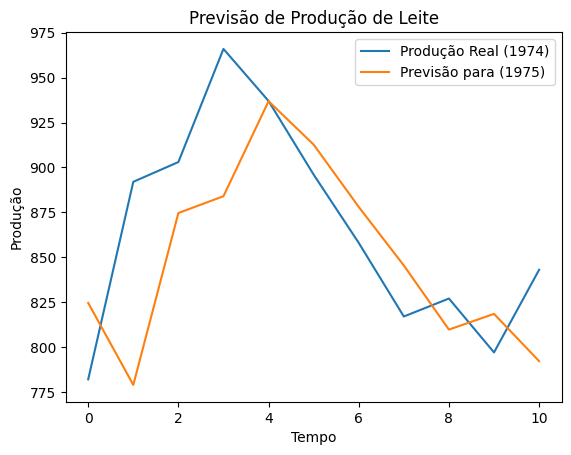

In [265]:
# Plotar resultados
plt.plot(y_test, label='Produção Real (1974)')
plt.plot(producao, label='Previsão para (1975)')
plt.title('Previsão de Produção de Leite')
plt.xlabel('Tempo')
plt.ylabel('Produção')
plt.legend()
plt.show()

Olhando o grafico no inicio da analise percebemos que todo ano foi a mesma coisa, Fevereiro o lucro é bem ruim mas começa a melhorar em Março e chega ao lucro maximo obtido por ano em Abril, e foi assim para os anos de 1962 - 1974. a previsão estimou que averia um ganho em janeiro por conta do mes de Dezembro que sempre almentou em relação ao mes anterios, nos passsos 2,3,6 percebemos as mesmas percas.  